In [35]:
!nvidia-smi

Fri Oct 16 16:26:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:01:00.0 Off |                  N/A |
| 41%   51C    P2    60W / 250W |  10451MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:02:00.0 Off |                  N/A |
| 29%   

In [36]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

import ase
from ase import Atoms

from tqdm.notebook import tqdm

In [37]:
tf.test.is_gpu_available()

True

# 1. Autoencoder

## 1.1 Make dataset

In [38]:
# Set path
path_r = Path("./MDtrajectory/reactant/dataset_reac.npz")
path_r_pe = Path("./MDtrajectory/reactant/dataset_reac_pe.npz")
path_p = Path("./MDtrajectory/product/dataset_prod.npz")
path_p_pe = Path("./MDtrajectory/product/dataset_prod_pe.npz")

#reactant
data_r = np.load(path_r)["arr_0"]
data_r_pe = np.load(path_r_pe)["arr_0"]
data_r_pe = data_r_pe.astype("float32")

#product
data_p = np.load(path_p)["arr_0"]
data_p_pe = np.load(path_p_pe)["arr_0"]
data_p_pe = data_p_pe.astype("float32")

print(data_r.shape, data_r_pe.shape, data_p.shape, data_p_pe.shape)

(100001, 6, 3) (100001,) (100001, 6, 3) (100001,)


In [39]:
## Making validation set
coord_1 = data_r[0].astype("float32")
coord_2 = data_p[0].astype("float32")

centroids = np.mean(coord_1, axis=0, keepdims=True)
coord_1 = coord_1 - centroids

centroids = np.mean(coord_2, axis=0, keepdims=True)
coord_2 = coord_2 - centroids

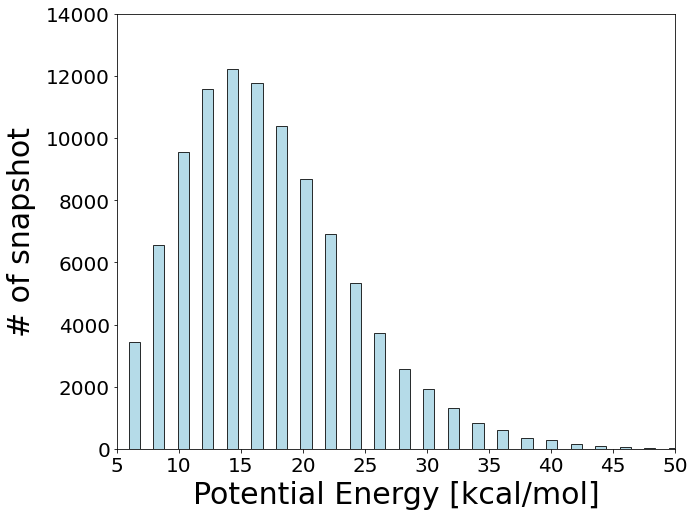

In [40]:
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(data_p_pe, bins=101, range=[0, 200], alpha = 0.9,color = "lightblue", edgecolor = "black", linewidth = 0.9, width = 0.9)

plt.xlabel("Potential Energy [kcal/mol]",fontsize = 30, labelpad = 5 ,family = 'Arial')
plt.ylabel("# of snapshot",fontsize = 30, labelpad = 10, family = 'Arial')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(5, 50)
plt.ylim(0, 14000)
plt.savefig("PB_no_sampling.png")
plt.show()

In [41]:
class Snapshot:
    def __init__(self, r, e):
        self.r = r
        self.e = e

def resample(coord, pe, size=100000, bins=100, eps=1e-3):
    hist, x = np.histogram(pe, bins=201)
    x = (x[1:] + x[:-1])*0.5 #set xticks
    
    prob = []
    for e in pe:
        i = np.argmin(np.abs(x-e))
        prob.append(hist[i] + eps) #get P(E)
    
    prob = 1 / np.array(prob)
    prob = prob / np.sum(prob) #normalize
    
    data = [Snapshot(r, e) for r, e in zip(coord, pe)]
    
    new_data = np.random.choice(data, size=size, p=prob) #sampling with probability 1/P(E)
    
    return new_data

In [42]:
new_data_r = resample(data_r, data_r_pe, bins=1000)
new_data_p = resample(data_p, data_p_pe, bins=1000)

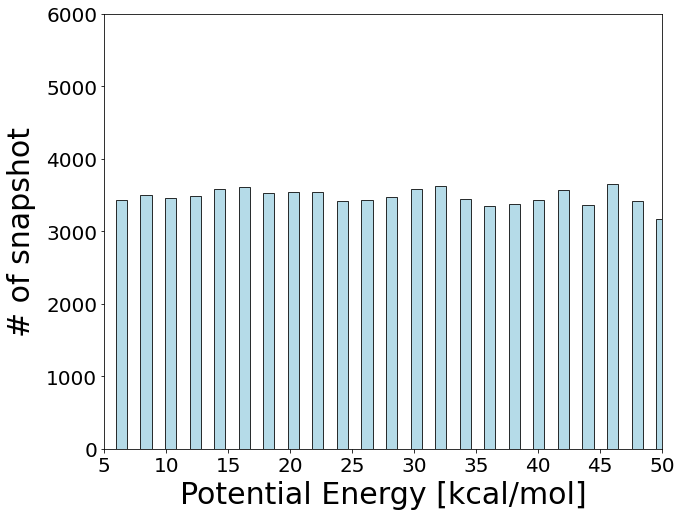

In [43]:
new_e = [s.e for s in new_data_p]

plt.hist(new_e,  bins=101, range=[0, 200],alpha = 0.9,color = "lightblue", edgecolor = "black", linewidth = 0.9, width = 0.9)

plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel("Potential Energy [kcal/mol]",fontsize = 30, labelpad = 5 ,family = 'Arial')
plt.ylabel("# of snapshot",fontsize = 30, labelpad = 10, family = 'Arial')
plt.rcParams["figure.figsize"] = (10,8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(5,50)
plt.ylim(0, 6000)
plt.savefig("PB_sampling.png")
plt.show()

In [44]:
data_r = [s.r for s in new_data_r]
data_p = [s.r for s in new_data_p]

## 1.3 Stacking R & P and Centroid

In [45]:
#stacking the database of reactant and product
data = np.vstack([data_r,data_p])
data = data.astype(dtype=np.float32)
print("this cell stacks with reactant and product")
print(data.shape)

this cell stacks with reactant and product
(200000, 6, 3)


In [46]:
#Skip nomaralization

# set the centeroids
centroids = np.mean(data, axis=1, keepdims=True)
data = data - centroids
data.shape

(200000, 6, 3)

In [47]:
train_idx = np.random.choice(200000, 150000, replace=False)
test_idx = list(set(list(range(200000))) - set(train_idx))
print(len(train_idx),len(test_idx))

150000 50000


In [48]:
# split train and test dataset
train_data = data[train_idx].astype("float32")
test_data = data[test_idx].astype("float32")

In [49]:
dataset = tf.data.Dataset.from_tensor_slices(train_data)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=50000)
#dataset = dataset.repeat()
dataset = dataset.batch(100)

## 1.4 Traninig Autoencoder

In [50]:
class Autoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.dropout = keras.layers.Dropout(0.1)
        
        self.encoding_layers = [
            keras.layers.Dense(units=128, activation=tf.nn.relu),
            keras.layers.Dense(units=64, activation=tf.nn.relu),
            keras.layers.Dense(units=32, activation=tf.nn.relu),
            keras.layers.Dense(units=6*3, activation=tf.nn.tanh)
        ]
        
        self.decoding_layers = [
            keras.layers.Dense(units=32, activation=tf.nn.relu),
            keras.layers.Dense(units=64, activation=tf.nn.relu),
            keras.layers.Dense(units=128, activation=tf.nn.relu),
            keras.layers.Dense(units=6*3),
        ]
        
    def encode(self, x):
        x = tf.reshape(x, shape=[-1, 6*3])
        for layer in self.encoding_layers:
            x = layer(x)
            
        return x
    
    def decode(self, x):
        for layer in self.decoding_layers:
            x = layer(x)
        x = tf.reshape(x, shape=[-1, 6, 3])

        return x
    
    def random_interpolate(self, x):
        encoding = autoencoder.encode(x) #[B,18]
        alpha = tf.random.uniform(shape=[tf.shape(x)[0], 1]) #[B,1]

        indice = tf.random.shuffle(tf.range(tf.shape(x)[0]))
        reordered_encoding = tf.gather(encoding, indice) #to solve the issues of gradients when using tf.random.shuffle
        interpolated_encoding = alpha*encoding + (1-alpha)*reordered_encoding

        decoding = autoencoder.decode(interpolated_encoding)
        
        return decoding

    @tf.function
    def call(self, x, training=False):
        interp_x = self.random_interpolate(x)
        #x = self.dropout(x, training=training)
        x = self.encode(x)
        x = self.decode(x)
        
        return x, interp_x

In [51]:
@tf.function
def calculate_dist_mat(r):
    # r = (B, N, 3)
    # r' = (B, 1, N, 3)
    # r'' = (B, N, 1, 3)
    # diffs = (B, N, N, 3)
    diffs = r[:, tf.newaxis, :, :] - r[:, :, tf.newaxis, :]
    # dist_mat = (B, N, N)
    dist_mat = tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1)+1e-8) 
      
    return dist_mat

## matrix
@tf.function
def calc_loss_xyz(y_true,y_pred):
    y_true = tf.reshape(y_true,[-1,1])
    y_pred = tf.reshape(y_pred,[-1,1])
    
    mse_xyz = tf.reduce_mean(tf.square(y_true-y_pred))
    return mse_xyz

@tf.function
def calc_loss_dist(y_true,y_pred):
    dist_true = calculate_dist_mat(y_true)
    dist_pred = calculate_dist_mat(y_pred)

    mse_dist = tf.reduce_mean(tf.square(dist_true - dist_pred))
    
    return mse_dist

@tf.function
def calc_loss_interp(interp_x, cutoff_interp_decoding = 1.0):   
    
    dist_mat_decoding = calculate_dist_mat(interp_x) #[B,6,6]    


    mask = tf.math.logical_and(tf.greater(dist_mat_decoding, 1e-3), tf.less(dist_mat_decoding, cutoff_interp_decoding))
    over_values = tf.boolean_mask(dist_mat_decoding, mask)
    
    if tf.shape(over_values)[0] == 0:
        return tf.constant(0.0)
    else:
        diff = over_values - cutoff_interp_decoding
        loss_interp_dist = tf.reduce_mean(tf.square(diff))
        return loss_interp_dist



## loss
@tf.function
def calculate_loss(y_true,y_pred,interp_x):
    
    mse_xyz = calc_loss_xyz(y_true,y_pred)
    mae_dist = calc_loss_dist(y_true,y_pred)    
    loss_interp = calc_loss_interp(interp_x)
    
    # Setting loss weight
    final_loss_xyz = mse_xyz
    final_loss_dist = mae_dist * 5
    final_loss_interp = loss_interp * 1e-1

    total_loss = final_loss_xyz  + final_loss_dist + final_loss_interp
    
    return total_loss, final_loss_xyz, final_loss_dist, final_loss_interp 

In [52]:
autoencoder = Autoencoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [53]:
@tf.function
def train_one_step(model, samples, optimizer):
    with tf.GradientTape() as tape:
        y_pred, interp_x = model(samples, training=True)
        loss, final_loss_xyz, final_loss_dist, final_loss_interp = calculate_loss(y_true=samples, y_pred=y_pred, interp_x=interp_x)
        
    grads = tape.gradient(loss, model.weights)
    optimizer.apply_gradients(zip(grads, model.weights))
    
    return y_pred, loss, final_loss_xyz, final_loss_dist, final_loss_interp

In [54]:
n_epoch = 50
batch_size = 100


np_ave_loss = []
list_test_loss = []
for epoch in range(n_epoch):

    print(f"{'Epoch':<10}{'Tota_loss':>15}{'xyz_loss':>15}{'dist_loss':>15}{'interp_loss':>15}")

    # Loss
    n_ave = 0
    ave_loss = np.array([0,0,0,0])  

    for i, samples in enumerate(dataset):
        y_pred, loss, final_loss_xyz, final_loss_dist, final_loss_interp = train_one_step(autoencoder, samples, optimizer)


        n_ave += 1
        ave_loss = ave_loss + (np.array([loss,final_loss_xyz,final_loss_dist,final_loss_interp]) - ave_loss)/n_ave
        if i%100 == 0:                        
            print(f"\r{epoch+1:<10}{ave_loss[0]:15.4f}{ave_loss[1]:15.4f}{ave_loss[2]:15.4f}{ave_loss[3]:15.4f}", end="")
    print("\n")
    
    test_pred, test_interp = autoencoder(test_data)
    (test_total_loss,test_loss_xyz,test_loss_dist,test_loss_interp) = calculate_loss(test_data, test_pred, test_interp)
    list_test_loss.append(test_total_loss.numpy())      
    
    np_ave_loss = np.concatenate([np_ave_loss,ave_loss],axis=0)



Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
1                  0.4666         0.1990         0.2660         0.0016

Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
2                  0.0888         0.0286         0.0594         0.0008

Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
3                  0.0572         0.0163         0.0402         0.0007

Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
4                  0.0432         0.0120         0.0305         0.0007

Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
5                  0.0342         0.0090         0.0246         0.0006

Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
6                  0.0284         0.0072         0.0206         0.0006

Epoch           Tota_loss       xyz_loss      dist_loss    interp_loss
7                  0.0251         0.0059         0.0186         0.0006


## 1.5 Generate initial guess for NEB

In [55]:
encoding_1 = autoencoder.encode(coord_1)
encoding_2 = autoencoder.encode(coord_2)

decoded_mats = [coord_1]
#for s in np.arange(0, 1+1e-5, 0.01):
for s in np.arange(0, 1, 0.067):
    interpolated_encoding = (1-s)*encoding_1 + s*encoding_2
    #print(interpolated_encoding)
    decoded = autoencoder.decode(interpolated_encoding)
    decoded = np.reshape(decoded, [6, 3])
    
    decoded_mats.append(decoded)
decoded_mats += [coord_2]

In [56]:
#decoded_mats
atoms_list = []
for i, mat in enumerate(decoded_mats):
    st = Atoms(symbols = 'HHHCCN', positions= decoded_mats[i])    
    atoms_list.append(st)

In [57]:
def atoms_list_to_xyz(filename, atoms_list):
    with open(filename, "w") as f:
        for atoms in atoms_list:
            f.write("%d\n\n" % len(atoms))
            for sym, pos in zip(atoms.symbols, atoms.positions):
                f.write("{} {} {} {}\n".format(sym, *pos))

In [58]:
atoms_list_to_xyz("./InitialGuess/aceT_nebguess.xyz", atoms_list)

## 2. LI

In [59]:
from ase.neb import NEB
from ase.optimize import MDMin, BFGS, FIRE
from ase import Atoms

In [60]:
initials = Atoms(symbols = 'HHHCCN', positions= coord_1)
finals = Atoms(symbols = 'HHHCCN', positions= coord_2)
images = [initials]
images += [initials.copy() for i in range(15)]
images += [finals]

In [61]:
neb = NEB(images)
neb.interpolate()
matrix = neb.get_positions()
# (B, 6, 3)
matrix = matrix.reshape(15,6,3)
#print(matrix)

In [62]:
atoms_list = []
atoms_list.append(initials)
for i, image in enumerate(matrix):
    st = Atoms(symbols = 'HHHCCN', positions= image)
    atoms_list.append(st)
atoms_list.append(finals)
atoms_list_to_xyz("./InitialGuess/aceT_LI.xyz", atoms_list)

## 3. IDPP

In [63]:
neb = NEB(images)
#FIRE로 한번하고 BFGS로 하면 좋은결과 나옴
neb.idpp_interpolate(optimizer=FIRE, fmax=0.01, steps=1000)

matrix = neb.get_positions()
# (B, 6, 3)
matrix = matrix.reshape(15,6,3)

/home/hspark8/anaconda3/envs/AE/lib/python3.6/site-packages/ase/utils/__init__.py:530: FutureWarning: Please use NEB's interpolate(method='idpp') method or directly call the idpp_interpolate function from ase.neb
  warnings.warn(warning)


In [64]:
atoms_list = []
atoms_list.append(initials)
for i, image in enumerate(matrix):
    st = Atoms(symbols = 'HHHCCN', positions= image)
    atoms_list.append(st)
atoms_list.append(finals)
atoms_list_to_xyz("./InitialGuess/aceT_IDPP.xyz", atoms_list)